<h1><center>Analyse des opinions par règles sur des données de twitter </center></h1>

<h1><center> 1. Objectif </center></h1>

Dans ce TP, nous allons effectuer une anlyse d’opinions sur un volume très réduit de données (˜500
échantillons) extraites de twitter. Ces échantillons de texte sont par nature de petite taille : ils contiennent
peu de mots, et donc peu d’éléments contextuels pour aider à l’entraînement et la prédiction de sentiments.
De plus, ils contiennent souvent des abréviations et des conventions langagières non-usuelles.
L’objectif de ce TP est donc d’analyser ce corpus de tweets à l’aide de règles, principalement basées
sur des ressources lexicales, comme des scores positifs ou négatifs associés à certain mots. Nous pourrons
travailler sans entraîner de classifieur (ce qui nécessiterait un nombre conséquent de tweets labellisés,
même si nous avions des représentations de mots pré-entraînées à disposition) mais nous devrons récupérer
et réfléchir à la meilleure manière d’exploiter les ressources disponibles.
Le TP est à rédiger en python et à rendre sous la forme d’un notebook (.ipynb) dans l’espace de rendu
dédié sur e-campus. Merci de mettre en valeur, quand il y a lieu, vos réponses aux questions et votre
démarche expérimentale.

<h1><center> 2. Documentation : Python et NLTK - Natural Language processing Toolkit </center></h1>

Vous aurez besoin d’une documentation sur NLTK :

— Le site de NLTK : http://www.nltk.org/

— La notice d’utilisation de l’interface de WordNet pour NLTK : http://www.nltk.org/howto/wordnet.html

— Et celle de l’interface de SentiWordNet, toujours pour NLTK : http://www.nltk.org/howto/sentiwordnet.html

— La notice d’utilisation du PoS tagger : http://www.nltk.org/book/ch05.html ... et, plus particulièrement, sur WordNet et SentiWordNet :

— Le site web de WordNet : http://wordnet.princeton.edu/

— Le site web de SentiWordNet : http://sentiwordnet.isti.cnr.it/

— Le site de Christopher Potts, qui explique comment utiliser WordNet avec NLTK, puis comment
utiliser SentiWordNet via un script (qui est désormais intégré à NLTK) : http://compprag. christopherpotts.net/wordnet.html

<h1><center> 3. Implémentation d’un système d’analyse d’opinions </center></h1>

<h1><center> 3.1. Présentation du corpus de tweets </center></h1>

Les tweets à analyser sont contenus dans l’archive testdata.manual.2009.06.14.csv. Cette base (Sentiment140) a été obtenue sur le site de l’université de Stanford : http://help.sentiment140.com/ for-students. Un extrait en est donné dans le tableau 1. La base contient 498 tweets annotés manuellement. La base propose 6 champs correspondant aux informations suivantes :

1. La polarité du tweet : Chaque tweet est accompagné d’un score pouvant être égal à 0 (négatif), 2(neutre) ou 4 (positif).

2. L’identifiant du tweet (2087)

3. La date du tweet (Sat May 16 23 :58 :44 UTC 2009)

4. La requête associée (lyx). Si pas de requête la valeur est NO_ QUERY.

5. L’utilisateur qui a tweeté (robotickilldozr)

6. Le texte du tweet (Lyx is cool)


<h1><center> 3.2. Prétraitements du corpus </center></h1>

Les tweets contiennent des caractères spéciaux susceptibles de nuire à la mise en place de nos méthodes
d’analyse d’opinions.

######  Écrire une fonction permettant pour chaque tweet de :

— Récupérer le texte associé

— Le segmenter en tokens

— Supprimer les urls

— Nettoyer les caractères inhérents à la structure d’un tweet (hashtags !)

— Corriger les abréviations et les spécificités langagières des tweets à l’aide du dictionnaire DicoSlang
(fichier SlangLookupTable.txt)

###### Vous ajouterez à votre fonction un moyen d’obtenir le nombre d’occurrences des hashtags, dont vous donnerez le compte sur l’ensemble du corpus.

In [4]:
#Import librairies
import os
import csv as csv
import pandas as pd
import nltk as nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import wordnet as wn
from nltk.corpus.reader import sentiwordnet as swn
from nltk.tag import map_tag
import re
from nltk.corpus import wordnet as wn
import codecs
import string


import warnings
warnings.filterwarnings("ignore")

#### Recupération des données

In [5]:
dataReader= pd.read_csv("testdata.manual.2009.06.14.csv",header=None,sep=",",names=["Polarite",
                             "Identifiant","Date","flag","user","text"])
dataReader.head()

,Polarite,Identifiant,Date,flag,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [6]:
n,p = dataReader.shape
dataReader.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Polarite     498 non-null    int64 
 1   Identifiant  498 non-null    int64 
 2   Date         498 non-null    object
 3   flag         498 non-null    object
 4   user         498 non-null    object
 5   text         498 non-null    object
dtypes: int64(2), object(4)
memory usage: 23.5+ KB


##### Ouverture du dictionnaire

In [7]:
#file = codecs.open("SlangLookupTable.txt", 'r', encoding="utf-8", errors='ignore')

In [8]:
file = pd.read_csv("SlangLookupTable.txt",encoding='windows-1254', delimiter = "\t", header=None,names=["Tweet",
                                                                                            "signification"])
file.head()

,Tweet,signification
0,121,one to one
1,a/s/l,"age, sex, location"
2,adn,any day now
3,afaik,as far as I know
4,afk,away from keyboard


In [9]:
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet          90 non-null     object
 1   signification  90 non-null     object
dtypes: object(2)
memory usage: 1.5+ KB


### Ecriture de notre fonction

In [10]:
#Suppression des urls
def strip_links(text):
    link_regex = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

def preProcessedTweet (text):
    #Sppressions des urls
    n_oc=text.count("#")
    text=strip_links(text)
    text=text.strip()
    #Suppression des hashtags
    text= text.replace('#',' ')
    #Suppression de @
    text= text.replace('@',' ')
    text=text.strip()
    #Suppression de la ponctuation
    text= word_tokenize(text)
    #Correction des abréviations et les spécificités langagières des tweets
    words=[]
    for element in text:
        if element in file["Tweet"].tolist():
            idx=file[file["Tweet"]==element].index
            words=words+file.loc[idx[0]]["signification"].split()
        else:
            words.append(element)
        if element in string.punctuation:
            idxx=text.index(element)
        #if element in string.punctuation:
    #Nombre de hashtags dans le corpus
    N_oc=sum([texte.count("#") for texte in dataReader["text"]])
    return N_oc, words
    

In [11]:
#Test avec le premier tweet
Test=preProcessedTweet(dataReader["text"][0])
Test

(52,
 ['stellargirl',
  'I',
  'loooooooovvvvvveee',
  'my',
  'Kindle2',
  '.',
  'Not',
  'that',
  'the',
  'DX',
  'is',
  'cool',
  ',',
  'but',
  'the',
  '2',
  'is',
  'fantastic',
  'in',
  'its',
  'own',
  'right',
  '.'])

In [12]:
nombre=preProcessedTweet(dataReader["text"][12])[0]
print(f"Le nombre d'occurence de  hashtag est de :  {nombre}") 

Le nombre d'occurence de  hashtag est de :  52


<h1><center> 3.3. Étiquetage grammatical </center></h1>

In [13]:
def taggedTweet(text):
    tokens= word_tokenize(text)
    taggedData = nltk.pos_tag(tokens)
    simplified_tags = [(word, map_tag('en-ptb', 'universal', tag)) for word, tag in taggedData]
    verbe=[]
    for element in simplified_tags:
        if element[1] == "VERB":
            verbe.append(element[1])
    nbre_verb= len(verbe)
    return simplified_tags, nbre_verb
    

In [14]:
taggedTweet(" ".join(preProcessedTweet(dataReader["text"][0])[1]))

([('stellargirl', 'NOUN'),
  ('I', 'PRON'),
  ('loooooooovvvvvveee', 'VERB'),
  ('my', 'PRON'),
  ('Kindle2', 'NOUN'),
  ('.', '.'),
  ('Not', 'ADV'),
  ('that', 'ADP'),
  ('the', 'DET'),
  ('DX', 'NOUN'),
  ('is', 'VERB'),
  ('cool', 'ADJ'),
  (',', '.'),
  ('but', 'CONJ'),
  ('the', 'DET'),
  ('2', 'NUM'),
  ('is', 'VERB'),
  ('fantastic', 'ADJ'),
  ('in', 'ADP'),
  ('its', 'PRON'),
  ('own', 'ADJ'),
  ('right', 'NOUN'),
  ('.', '.')],
 3)

In [15]:
Nbre_verb=0
for element in dataReader["text"]:
    Nbre_verb += taggedTweet(" ".join(preProcessedTweet(element)[1]))[1]
print(f"Le nombre de mots étiquetés verbes dans le corpus est de :  {Nbre_verb}")

Le nombre de mots étiquetés verbes dans le corpus est de :  1169


<h1><center> 3.4. Algorithme de détection : utilisation du dictionnaire Sentiwordnet </center></h1>

###### Ecrire d'une fonction permettant :

- De récupérer uniquement les mots correspondant à des adjectifs, noms, adverbes et verbe,

- D’accéder aux scores (positifs et négatifs) des synsets,

- De calculer pour chaque mot les scores associés à leur premier synset,

- De calculer pour chaque tweet la somme des scores positifs et négatifs des synsets du tweet,

- De comparez la somme des scores positifs et des scores négatifs de chaque tweet pour décider de la
 classe à associer au tweet.

In [16]:
#Exemple
dicoSentiWordnetFile = 'SentiWordNet_3.0.0_20130122.txt'
swn_dict = swn.SentiWordNetCorpusReader('', [dicoSentiWordnetFile])


In [17]:
def getsentiment(text):
    taggedtweet= taggedTweet(" ".join(preProcessedTweet(text)[1]))
    posscore = 0
    negscore = 0
    synsets = None
    evaluedwords=["ADJ","NOUN","VERB","ADP"]
    for element in taggedtweet[0]:
        if element[1] in  evaluedwords:
            synsets =  swn_dict.senti_synsets(element[0])
        if synsets != None:
            synsets = list(synsets)
            if len(synsets) > 0:
                synset = synsets[0]
                posscore = posscore + synset.pos_score()
                negscore = negscore + synset.neg_score()
    if posscore > negscore:
        return (posscore , negscore, 4)
    elif negscore > posscore:
        return (posscore, negscore, 0)
    else:
        return (posscore, negscore,2)    

In [18]:
getsentiment(dataReader["text"][0])

(2.125, 2.125, 2)

In [19]:
y_pred=[getsentiment(dataReader["text"][i])[2] for i in range(n)]
y_pred = pd.Series(y_pred)
y_true=dataReader["Polarite"]

In [20]:
# Nombre de tweets correctement classifiés
(y_true.values == y_pred.values).sum()

271

In [21]:
# Accuracy
((y_true.values == y_pred.values).sum()/n )*100

54.41767068273092

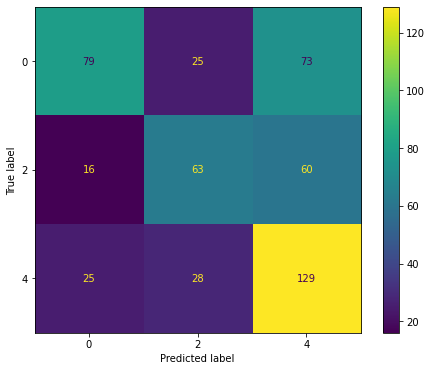

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize = (8,6))
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot(ax = ax)
ax.xaxis.set_ticklabels(['0', '2', '4'])
ax.yaxis.set_ticklabels(['0', '2', '4'])
#plt.title()
plt.show()

<h1><center> 3.5. Algorithme de détection : gestion de la négation et des modifieurs </center></h1>

In [23]:
fichierneg=pd.read_csv("NegatingWordList.txt", names=["negation"])
fichierneg = fichierneg.values

In [24]:
fichierneg

array([["aren't"],
       ['arent'],
       ["can't"],
       ['cannot'],
       ['cant'],
       ["don't"],
       ['dont'],
       ["isn't"],
       ['isnt'],
       ['never'],
       ['not'],
       ["won't"],
       ['wont'],
       ["wouldn't"],
       ['wouldnt']], dtype=object)

In [25]:
Boostword=pd.read_csv("BoosterWordList.txt", sep='\t', names=["modifieur","valeur","commentaire"])
Boostword = list(Boostword["modifieur"])
Boostword

['absolutely',
 'definitely',
 'extremely',
 'fuckin',
 'fucking',
 'hugely',
 'incredibly',
 'just',
 'overwhelmingly',
 'so',
 'some',
 'sum',
 'very']

In [26]:
def gestnegmodif(text):
    taggedtweet= taggedTweet(" ".join(preProcessedTweet(text)[1]))
    #Initialisation
    posscore = 0
    negscore = 0
    nb_neg = 0
    synsets = None
    precedent_est_modifieur = False
    precedent_est_negatif = False
    #Mots evalues
    kindevaluedwords=["ADJ","NOUN","VERB","ADP"]
    evaluedwords=[element for element in taggedtweet[0] if element[1] in kindevaluedwords]
    for word, tag in evaluedwords:
        #posscore += swn_dict.senti_synsets(word).pos_score()
        #negscore += swn_dict.senti_synsets(word).neg_score()
        
        synsets = swn_dict.senti_synsets(word)
        if synsets != None:
            synsets=list(synsets)
            if len(synsets)>0:
                synset = synsets[0]
                if precedent_est_negatif == True:
                    if precedent_est_modifieur == True:
                        posscore += synset.neg_score() *2
                        negscore += synset.pos_score() *2
                    else:
                        posscore += synset.neg_score()
                        negscore += synset.pos_score()

                else:
                    if precedent_est_modifieur == True:
                        posscore += synset.pos_score() *2
                        negscore += synset.neg_score() *2

                    else:
                        posscore +=synset.pos_score()
                        negscore += synset.neg_score()

                if word in Boostword:
                    precedent_est_modifieur = True
                if word in fichierneg:
                    precedent_est_negatif = True
                    nb_neg += 1
    
    if posscore > negscore:
        return (posscore , negscore, 4,nb_neg)
    elif negscore > posscore:
        return (posscore, negscore, 0, nb_neg)
    else:
        return (posscore, negscore,2, nb_neg) 

In [27]:
y_pred=[gestnegmodif(dataReader["text"][i])[2] for i in range(n)]
y_pred = pd.Series(y_pred)
y_true=dataReader["Polarite"]
y_pred

0      4
1      4
2      2
3      4
4      2
      ..
493    4
494    0
495    2
496    0
497    0
Length: 498, dtype: int64

In [28]:
# Nombre de tweets correctement classifiés
(y_true.values == y_pred.values).sum()

267

In [29]:
# Accuracy
((y_true.values == y_pred.values).sum()/n )*100

53.6144578313253

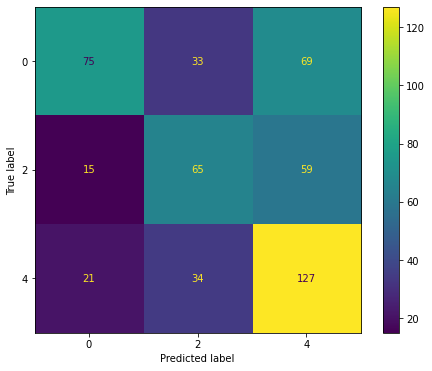

In [30]:
fig, ax = plt.subplots(1,1, figsize = (8,6))
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot(ax = ax)
ax.xaxis.set_ticklabels(['0', '2', '4'])
ax.yaxis.set_ticklabels(['0', '2', '4'])
#plt.title()
plt.show()

In [31]:
print(f"Sur un total de 182 tweets positifs, 127 ont été correctement prédits")
print(f"Sur un total de 139 tweets neutres, 65 ont été correctement prédits")
print(f"Sur un total de 177 tweets négatifs, 75 ont été correctement prédits")

Sur un total de 182 tweets positifs, 127 ont été correctement prédits
Sur un total de 139 tweets neutres, 65 ont été correctement prédits
Sur un total de 177 tweets négatifs, 75 ont été correctement prédits


In [32]:
Nb_neg=[gestnegmodif(dataReader["text"][i])[3] for i in range(n)]
Nb_neg=sum(Nb_neg)
print(f" Le nombre de termes négatifs contenus dans les tweets positifs est de  :  {Nb_neg}")

 Le nombre de termes négatifs contenus dans les tweets positifs est de  :  4


<h1><center> 3.6. Algorithme de détection : gestion des émoticones </center></h1>

In [33]:
Emoticone=pd.read_csv("EmoticonLookupTable.txt",on_bad_lines='skip',sep="\t",names=["icone","valeur"])
Emoticone["icone"].values

array(['%-(', '%-)', '(-:', '(:', '(^ ^)', '(^-^)', '(^.^)', '(^_^)',
       '(o:', '(o;', ')-:', '):', ')o:', '*)', '*\\o/*', '--^--@', '0:)',
       '38*', '8)', '8-)', '8-0', '8/', '8\\', '8c', ':#', ":'(", ":'-(",
       ':(', ':)', ':*(', ':,(', ':-&', ':-(', ':-(o)', ':-*', ':-*',
       ':-/', ':-/', ':-D', ':-O', ':-P', ':-S', ':-\\', ':-\\', ':-|',
       ':-}', ':/', ':0->-<|:', ':3', ':9', ':D', ':E', ':F', ':O', ':P',
       ':P', ':S', ':X', ':[', ':[', ':\\', ':]', ':_(', ':b)', ':l',
       ':o(', ':o)', ':p', ':s', ':|', ':|', ':?', ':?(', ';)', ';^)',
       ';o)', '</3-1', '<3', '<:}', '<o<', '=(', '=)', '=[', '=]', '>/',
       '>:(', '>:)', '>:D', '>:L', '>:O', '>=D', '>[', '>\\', '>o>',
       '@}->--', 'B(', 'Bc', 'D:', 'X(', 'X(', 'X-(', 'XD', 'XD', 'XO',
       'XP', 'XP', '^_^', '^o)', 'x3?', 'xD', 'xP', '|8C', '|8c', '|D',
       '}:)'], dtype=object)

In [34]:
# Séparation des émoticones en listes d"émoticones positives, négatives et neutre 
Emotpos= Emoticone[Emoticone["valeur"]==1]["icone"].values
Emotneg= Emoticone[Emoticone["valeur"]==-1]["icone"].values
Emotneut= Emoticone[Emoticone["valeur"]==0]["icone"].values

In [35]:
# Nouvelle fonction de preprocessing

#import TweetTokenizer() method from nltk
from nltk.tokenize import TweetTokenizer

# Create a reference variable for Class TweetTokenizer
tk = TweetTokenizer(strip_handles=True)



#Suppression des urls et des noms d'utilisateurs
def strip_links(text):
    link_regex = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ') 
    return text

def preProcessedTweets (text):
    
    #Sppressions des urls
    n_oc=text.count("#")
    text=strip_links(text)
    text=text.strip()
    #Suppression des hashtags
    text= text.replace('#',' ')
    text=text.strip()
    #Suppression de la ponctuation
    text= tk.tokenize(text)
    #Correction des abréviations et les spécificités langagières des tweets
    words=[]
    for element in text:
        if element in file["Tweet"].tolist():
            idx=file[file["Tweet"]==element].index
            words=words+file.loc[idx[0]]["signification"].split()
        else:
            words.append(element)
        if element in string.punctuation:
            idxx=text.index(element)
        #if element in string.punctuation:
    #Nombre de hashtags dans le corpus
    N_oc=sum([texte.count("#") for texte in dataReader["text"]])
    return N_oc, words

In [36]:
#Test avec le premier tweet
Test=preProcessedTweets(dataReader["text"][4])[1]
Test

['Fair',
 'enough',
 '.',
 'But',
 'i',
 'have',
 'the',
 'Kindle',
 '2',
 'and',
 'I',
 'think',
 "it's",
 'perfect',
 ':)']

In [37]:
def gestemotic(text,postemot,negemot):
    taggedtweet= taggedTweet(" ".join(preProcessedTweets(text)[1]))
    posscore = 0
    negscore = 0
    emopos = 0
    emoneg= 0
    synsets = None
    kindevaluedwords=["ADJ","NOUN","VERB","ADP"]
    evaluedwords=[element for element in taggedtweet[0] if element[1] in kindevaluedwords]
    for element in preProcessedTweets(text)[1]:
        if element in postemot:
            emopos +=1
        if element in negemot:
            emoneg +=1
    for couple in taggedtweet[0]:
        if couple in  evaluedwords:
            synsets =  swn_dict.senti_synsets(couple[0])
        if synsets != None:
            synsets = list(synsets)
            if len(synsets) > 0:
                synset = synsets[0]
                posscore = posscore + synset.pos_score()
                negscore = negscore + synset.neg_score()
    posscore=posscore + emopos
    negscore = negscore + emoneg
    if posscore > negscore:
        return (posscore , negscore, 4)
    elif negscore > posscore:
        return (posscore, negscore, 0)
    else:
        return (posscore, negscore,2)   

In [38]:
y_pred=[gestemotic(dataReader["text"][i],Emotpos,Emotneg)[2] for i in range(n)]
y_pred = pd.Series(y_pred)
y_true=dataReader["Polarite"]

In [39]:
# Nombre de tweets correctement classifiés
(y_true.values == y_pred.values).sum()

285

In [40]:
# Accuracy
((y_true.values == y_pred.values).sum()/n )*100

57.22891566265061

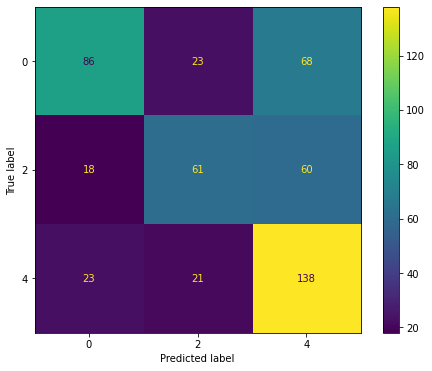

In [41]:
fig, ax = plt.subplots(1,1, figsize = (8,6))
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot(ax = ax)
ax.xaxis.set_ticklabels(['0', '2', '4'])
ax.yaxis.set_ticklabels(['0', '2', '4'])
#plt.title()
plt.show()

In [40]:
print(f"Sur un total de 182 tweets positifs, 138 ont été correctement prédits")
print(f"Sur un total de 139 tweets neutres, 86 ont été correctement prédits")
print(f"Sur un total de 177 tweets négatifs, 61 ont été correctement prédits")

Sur un total de 182 tweets positifs, 138 ont été correctement prédits
Sur un total de 139 tweets neutres, 86 ont été correctement prédits
Sur un total de 177 tweets négatifs, 61 ont été correctement prédits


In [41]:
Taggedtweets = [preProcessedTweets(dataReader["text"][i])[1] for i in range(n)]

Nb_emot=0
for tagtweet in Taggedtweets:
    for tagword in tagtweet:
        if tagword in list(Emoticone["icone"].values):
            Nb_emot +=1
print(f"le nombre d'émoticones dans le corpus est de {Nb_emot}")

le nombre d'émoticones dans le corpus est de 59


<h1><center> 3.7.  Algorithme de détection : ma version vs Vader </center></h1>

In [42]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
def sentimentScore(sentences):
    sia = SentimentIntensityAnalyzer()
    Results=pd.DataFrame()
    for sentence in sentences:
        result = sia.polarity_scores(sentence)
        result = pd.DataFrame([result])
        Results=pd.concat([Results,result],axis=0)
    return Results

In [43]:
list(dataReader["text"].values)

['@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.',
 'Reading my kindle2...  Love it... Lee childs is good read.',
 'Ok, first assesment of the #kindle2 ...it fucking rocks!!!',
 "@kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)",
 "@mikefish  Fair enough. But i have the Kindle2 and I think it's perfect  :)",
 "@richardebaker no. it is too big. I'm quite happy with the Kindle2.",
 'Fuck this economy. I hate aig and their non loan given asses.',
 'Jquery is my new best friend.',
 'Loves twitter',
 'how can you not love Obama? he makes jokes about himself.',
 "Check this video out -- President Obama at the White House Correspondents' Dinner http://bit.ly/IMXUM",
 "@Karoli I firmly believe that Obama/Pelosi have ZERO desire to be civil.  It's a charade and a slogan, but they want to destroy conservatism",
 'House Correspondents dinner 

In [44]:
Vad_result=sentimentScore(list(dataReader["text"].values))
Vad_result.head()

,neg,neu,pos,compound
0,0.000,0.627,0.373,0.8373
0,0.000,0.530,0.470,0.7964
0,0.000,0.722,0.278,0.4724
0,0.122,0.593,0.285,0.7772
0,0.000,0.457,0.543,0.8934


In [47]:
y_Vadpred=[]
for i in range(Vad_result.shape[0]):
    if Vad_result.iloc[i]["pos"] > Vad_result.iloc[i]["neg"]:
         y_Vadpred.append(4)
    elif Vad_result.iloc[i]["pos"] < Vad_result.iloc[i]["neg"]:
        y_Vadpred.append(0)
    else:
        y_Vadpred.append(2)  


In [49]:
y_pred = pd.Series(y_Vadpred)
y_true=dataReader["Polarite"]

In [50]:
# Nombre de tweets correctement classifiés
(y_true.values == y_pred.values).sum()

356

In [51]:
# Accuracy
((y_true.values == y_pred.values).sum()/n )*100

71.4859437751004

Les performances performances de Vader sont meilleures. 


On peut faire plus de nettoyage du corpus (enlever tous les stop-word par exemple).